In [36]:
import numpy as np
import matplotlib.pyplot as plt

import vci

In [37]:
extra_kps = [1, 2, 5, 6, 11, 12, 16, 17, 21, 22, 26, 27, 29]
skeleton = [
    [16, 17],
    [16, 10],
    [16, 13],
    [14, 13],
    [14, 15],
    [11, 10],
    [11, 12],
    [8, 7],
    [8, 9],
    [5, 4],
    [5, 6],
    [0, 16],
    [0, 3],
    [0, 4],
    [0, 7],
    [0, 1],
    [0, 2],
    [3, 1],
    [3, 2],
]

# the idea

For each edge in the skeleton I compute its size. Repeat this for all frames, obtaining a tensor with shape `(n_frames, n_edges)`. Then I select only the frames in which more than 80% of the edges are between the 0.3- and 0.7-quantiles. After that I extract all periods of time with at least 1s and then I extract the 1s intervals.

In [124]:
keypoints = np.load("bex_20230226/keypoints/keypoints.npy")
keypoints = np.delete(keypoints, extra_kps, axis=1)

distances = np.empty((len(skeleton), len(keypoints)))  # (n_edges, n_frames)
quantiles = np.empty((len(skeleton), 2))
percent = 0.8
fst_qtl = 0.2
snd_qtl = 0.8

# compute the distance of each edge for all frames
for i, edge in enumerate(skeleton):
    distances[i] = np.linalg.norm(
        keypoints[:, edge[0]] - keypoints[:, edge[1]], axis=1
    )

# compute the quantiles of the distances across frame for each edge
for i, edge in enumerate(distances):
    quantiles[i, 0] = np.quantile(edge, fst_qtl)
    quantiles[i, 1] = np.quantile(edge, snd_qtl)

# for each frame check if 80% of the distances is within the quantiles
frames = []
for i in range(distances.shape[1]):
    if len(
        [
            j
            for j in range(distances.shape[0])
            if quantiles[j][0] < distances[j, i] < quantiles[j][1]
        ]
    ) > percent * len(skeleton):
        frames.append(i)

In [125]:
consec = []
start = frames[0]
end = frames[0]

for i in range(1, len(frames)):
    if frames[i] < end + 5000:
        end = frames[i]
    else:
        consec.append([start, end])
        start = frames[i]
        end = frames[i]

consec.append([start, end])
print(consec)

[[2453, 35921], [41803, 52870], [78916, 122022], [145867, 196439]]


In [132]:
vci.plot.plot_pose(keypoints[26000], skeleton)

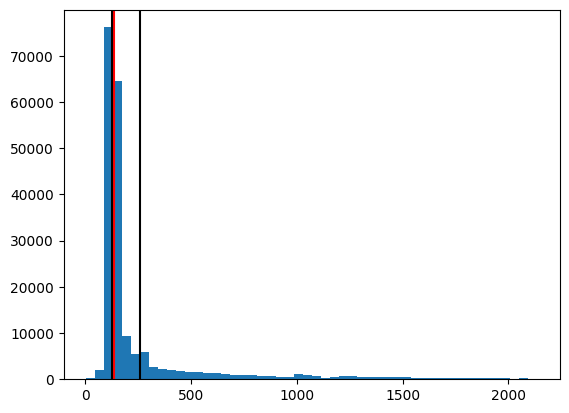

In [79]:
i=6
plt.hist(distances[i], bins=50)
plt.axvline(np.median(distances[i]), color="red")
plt.axvline(np.quantile(distances[i], 0.2), color="black")
plt.axvline(np.quantile(distances[i], 0.8), color="black")